Source code: https://www.kaggle.com/code/cedrikewers/landmarkrecognition

In [1]:
# test
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image
import numpy as np

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f'Using device: {device}')


Using device: cuda


## Load the data

In [2]:
# Data augmentation and normalization are applied to the images
transform = transforms.Compose([
    transforms.RandomResizedCrop(100),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Loading and preprocessing the dataset(Selects top classes and splits dataset).
class CustomImageDataset(Dataset):
    def __init__(self, labels, root_dir, transform, top_classes=3, train=True):
        labels_df = pd.read_csv(labels, dtype=({"id": str, "landmark_id": np.uint64}))
        
        # Shuffle dataframe in a predictable manner and only select the top 70%
        labels_df = labels_df.sample(frac=1, random_state=42).reset_index(drop=True)
        label_counts = labels_df.value_counts("landmark_id")
        if train:
            dataset_size = int(len(labels_df) * 0.7)
            labels_df = labels_df.head(dataset_size)
        else:
            dataset_size = int(len(labels_df) * 0.3)
            labels_df = labels_df.tail(dataset_size)
        
        used_pictures = labels_df.where(labels_df["landmark_id"] == label_counts.index[0]).dropna()
        
        mapping = {label_counts.index[0]: 0}

        for i in range(1, top_classes):
            mapping[label_counts.index[i]] = i
            used_pictures = pd.concat([used_pictures, labels_df.where(labels_df["landmark_id"] == label_counts.index[i]).dropna()])
        
        used_pictures.replace(mapping, inplace=True)
        print(mapping)
        self.labels_df = used_pictures
        
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name[0], img_name[1], img_name[2], img_name + ".jpg")
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = int(self.labels_df.iloc[idx, 1])
        
        return image, label

train_dataset = CustomImageDataset(labels="/kaggle/input/landmark-recognition-2020/train.csv", root_dir="/kaggle/input/landmark-recognition-2020/train", transform=transform, top_classes=10)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = CustomImageDataset(labels="/kaggle/input/landmark-recognition-2020/train.csv", root_dir="/kaggle/input/landmark-recognition-2020/train", transform=transform, train=False, top_classes=10)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

{138982: 0, 126637: 1, 20409: 2, 83144: 3, 113209: 4, 177870: 5, 194914: 6, 149980: 7, 139894: 8, 1924: 9}
{138982: 0, 126637: 1, 20409: 2, 83144: 3, 113209: 4, 177870: 5, 194914: 6, 149980: 7, 139894: 8, 1924: 9}


## Define the Model
A simple Convolutional Neural Network (CNN):

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
# Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bnet1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bnet2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bnet3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bnet4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bnet5 = nn.BatchNorm2d(512)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)  # Adjust input size based on pooling
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Convolutional layers with batch normalization and pooling
        x = self.pool(F.relu(self.bnet1(self.conv1(x))))
        x = self.pool(F.relu(self.bnet2(self.conv2(x))))
        x = self.pool(F.relu(self.bnet3(self.conv3(x))))
        x = self.pool(F.relu(self.bnet4(self.conv4(x))))
        x = self.pool(F.relu(self.bnet5(self.conv5(x))))

        # Flatten the tensor for fully connected layers
        x = x.view(-1, 512 * 3 * 3)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
num_classes = 10

## Train multiple models for ensemble averaging
## 

In [4]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

num_epochs = 30
num_models = 3  # Number of models to train
models = [] # List to store models

for model_idx in range(num_models):
    model = SimpleCNN(num_classes)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # L2 REGULARIZATION 
    scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)  # Learning rate scheduler (decreases learning rate every 20 epochs by 0.1)
    criterion = nn.CrossEntropyLoss()
    
    # Early stopping params
    patience = 5  
    loss_best_val = float('inf')  
    patience_ct = 0  

    print(f"Starting training for model {model_idx + 1}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad() # Zero the parameter gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Compute loss with Loss function
            loss.backward() # Backward pass
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # GRADIENT CLIPPING
            optimizer.step() # Optimize
            running_loss += loss.item() * inputs.size(0) 

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Model {model_idx + 1}, Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        scheduler.step() #Decreases learning rate after called the amount of times defined by "step_size"

        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader.dataset)
        accuracy = correct / total
        print(f'Model {model_idx + 1} Validation Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')
        
        #dded for early stopping
        if test_loss < loss_best_val:  
            loss_best_val = test_loss  
            patience_ct = 0  #
            torch.save(model.state_dict(), f'/kaggle/working/model_{model_idx + 1}.pth')
        else:
            patience_ct += 1 
            if patience_ct >= patience:  
                print("Early stopping")  
                break  
    # Save the trained model
    torch.save(model.state_dict(), f'/kaggle/working/model_{model_idx + 1}.pth')
    models.append(model)

Starting training for model 1
Model 1, Epoch 1/30, Loss: 2.5321
Model 1 Validation Loss: 2.0824, Accuracy: 0.2913
Model 1, Epoch 2/30, Loss: 1.4274
Model 1 Validation Loss: 1.5064, Accuracy: 0.5133
Model 1, Epoch 3/30, Loss: 1.2485
Model 1 Validation Loss: 1.5719, Accuracy: 0.4677
Model 1, Epoch 4/30, Loss: 1.1295
Model 1 Validation Loss: 1.1828, Accuracy: 0.6150
Model 1, Epoch 5/30, Loss: 0.9896
Model 1 Validation Loss: 1.0021, Accuracy: 0.6581
Model 1, Epoch 6/30, Loss: 0.9442
Model 1 Validation Loss: 0.9699, Accuracy: 0.6827
Model 1, Epoch 7/30, Loss: 0.8673
Model 1 Validation Loss: 0.9586, Accuracy: 0.6835
Model 1, Epoch 8/30, Loss: 0.8429
Model 1 Validation Loss: 0.8768, Accuracy: 0.7079
Model 1, Epoch 9/30, Loss: 0.8201
Model 1 Validation Loss: 0.8090, Accuracy: 0.7306
Model 1, Epoch 10/30, Loss: 0.7937
Model 1 Validation Loss: 0.8033, Accuracy: 0.7340
Model 1, Epoch 11/30, Loss: 0.7555
Model 1 Validation Loss: 1.0043, Accuracy: 0.6729
Model 1, Epoch 12/30, Loss: 0.7313
Model 1 V

# Testing with ensemble averaging

{138982: 0, 126637: 1, 20409: 2, 83144: 3, 113209: 4, 177870: 5, 194914: 6, 149980: 7, 139894: 8, 1924: 9}
Accuracy: 0.8750
Got 25/200 wrong (12.50%)


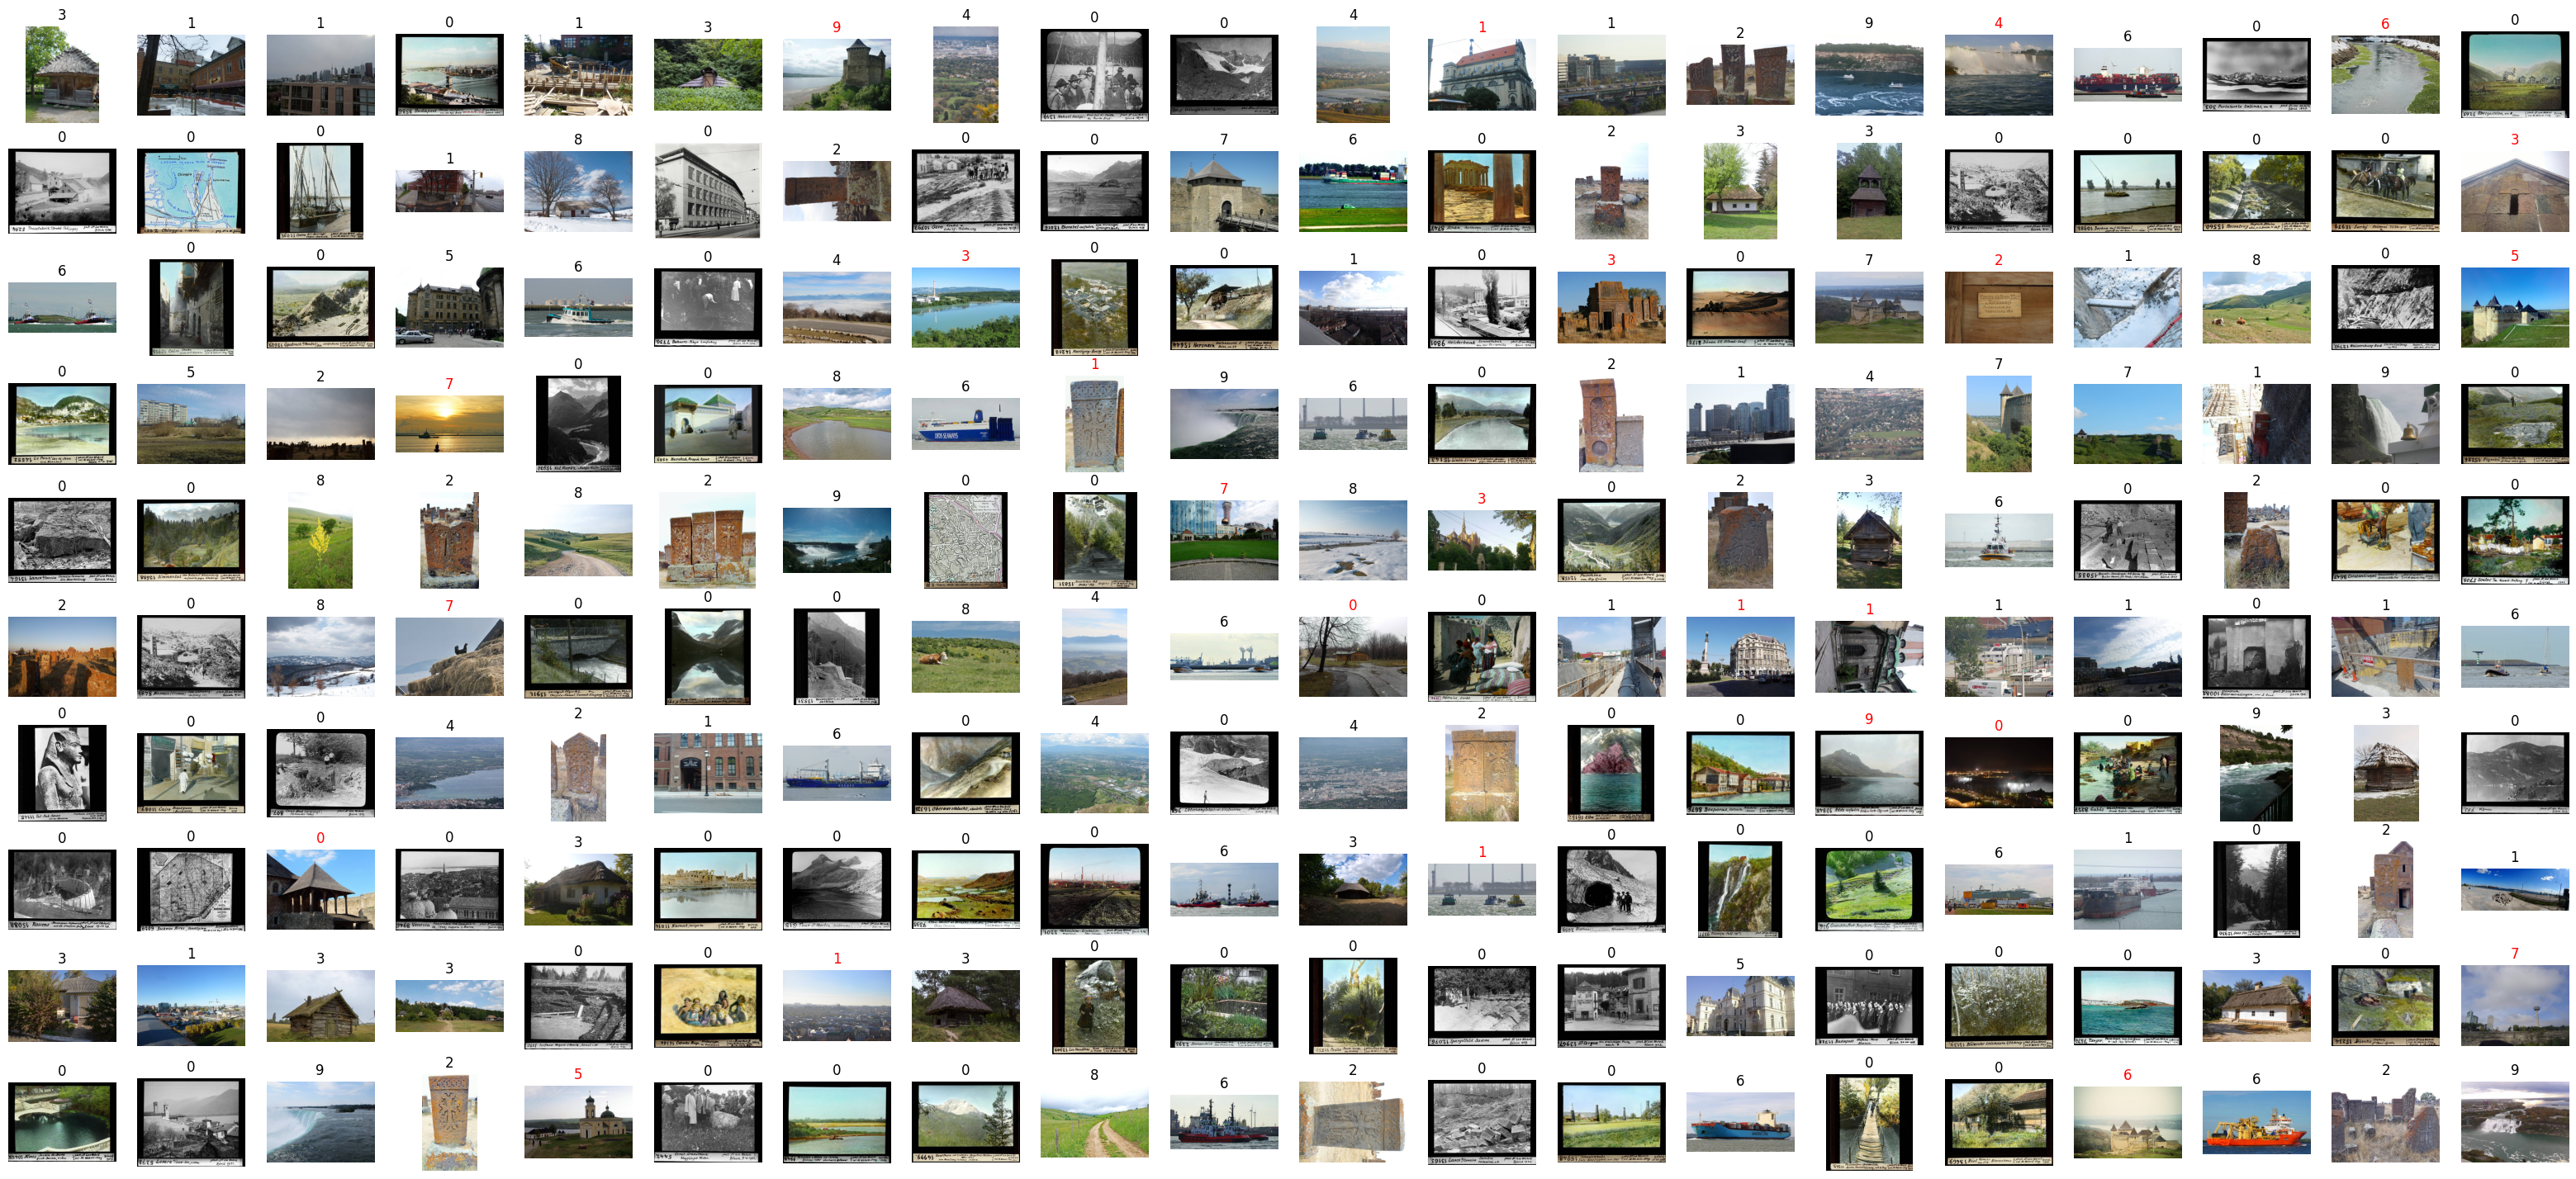

In [5]:
import matplotlib.pyplot as plt

# Load the models for testing
for model_idx in range(num_models):
    model = SimpleCNN(num_classes)
    model.load_state_dict(torch.load(f'/kaggle/working/model_{model_idx + 1}.pth'))
    model.to(device)
    model.eval()
    models[model_idx] = model

# Define the function for ensemble prediction
def ensemble_predict(image):
    with torch.no_grad():
        outputs = [model(image) for model in models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        _, predicted = torch.max(avg_output, 1)
        return int(predicted)

# Evaluate the model on the test dataset
test_dataset = CustomImageDataset(labels="/kaggle/input/landmark-recognition-2020/train.csv", root_dir="/kaggle/input/landmark-recognition-2020/train", transform=transform, train=False, top_classes=10)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

correct = 0
total = 0
wrong_count = 0

fig, axs = plt.subplots(10, 20, figsize=(40, 18))

for j in range(10):
    for i in range(20):
        number = np.random.randint(0, len(test_dataset))
        img_name = test_dataset.labels_df.iloc[number]["id"]
        img_path = os.path.join(test_dataset.root_dir, img_name[0], img_name[1], img_name[2], img_name + ".jpg")
        pil_im = Image.open(img_path, 'r')
        ax = axs[j][i]
        ax.imshow(np.asarray(pil_im))
        ax.axis("off")

        image, label = test_dataset[number]
        image = image.unsqueeze(0).to(device) # Apply transformations and add batch dimension
        pred_label = ensemble_predict(image)
        color = "r" if pred_label != label else "k"
        ax.set_title(pred_label, color=color)

        if color == "r":
            wrong_count += 1
        total += 1
        correct += (pred_label == label)

accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')
print(f"Got {wrong_count}/{total} wrong ({wrong_count/total:.2%})")
plt.savefig("/kaggle/working/testing_ensemble.png")